1. Predicting temperature
In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of this dataset from Kaggle. To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

First, load the dataset from the weatherinszeged table from Thinkful's database.

Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.

Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

Here are the credentials you can use to connect to the database:

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'
As in earlier assignments, be sure to close the database connection after initially pulling in your data.

In [3]:
#importing numpy, pandas, sklearn, pyplot, sqlalchemy 
import pandas as pd #for dataframe
import numpy as np #linear algebra libraries
import matplotlib.pyplot as plt #visualization
import seaborn as sns # seaborn for visualization
import math #statistics
import scipy.stats as stats #for ttest
from sklearn.preprocessing import StandardScaler # for standardization and normalization
from sklearn.decomposition import PCA #to reduce Linear dimensionality
from sklearn.preprocessing import normalize #for normalization
from sklearn.preprocessing import scale #for standardization
from sqlalchemy import create_engine # for open connection of SQL and python
import statsmodels.api as sm
from sklearn import linear_model
import warnings

warnings.filterwarnings('ignore')

In [4]:
#openning postgre for weatherinszeged table
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

Next, we load the data from the PostgreSQL database and print out some observations:

In [5]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
weather = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


weather.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [6]:
#lets copy the file 
weather_c = weather.copy()

#### Info: to find the nature of data:

In [7]:
weather_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


OBS:
From above we can see that there is no null value, and all the dtype looks okay.

there is datetime, float, and object dtypes and only 8.8+ MB memory used.

In [8]:
weather_c.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


OBS:
Humidity could not be 0, so nedd to fix it.
windspeed 0 that means air might be calm.
loudcover got all 0, which means it misses all the data need to drop it.



Lets replace all the zeros on humidity to missing values.

weather_c['humidity'].replace(0, np.nan, inplace = True)


In [9]:
weather_c.drop('loudcover', axis = 1, inplace=True)

Before fixing all the missing values, lets make date easier to read and write.

In [10]:
#'Formatted Date' transformation:

weather_c['date'] = pd.to_datetime(weather_c['date'])
weather_c['year'] = weather_c['date'].dt.year
weather_c['month'] =weather_c['date'].dt.month
weather_c['day'] = weather_c['date'].dt.day
weather_c['hour'] = weather_c['date'].dt.hour

In [11]:
#checking for new columns/features
weather_c.columns

Index(['date', 'summary', 'preciptype', 'temperature', 'apparenttemperature',
       'humidity', 'windspeed', 'windbearing', 'visibility', 'pressure',
       'dailysummary', 'year', 'month', 'day', 'hour'],
      dtype='object')

### Data Cleaning:

#lets clean humidity data
#grouping all the features by year
grouped_year = weather_c.groupby('year', as_index = False)


#filling all missing values with their mean grouping by country
weather_c = grouped_year.apply(lambda x: x.fillna(x.mean))


Now we can see there is no more missing values, so lets move to next step.

### Data Exploration:

In [12]:
#lets see unique attributes of categorical features
cols = weather_c[['summary', 'preciptype', 'dailysummary']]

for column in cols:
    print("--Unique values in column {} are:\n {}, \n unique number is : {}, \n value count is: \n{}"
          .format(column, weather_c[column].unique(), weather_c[column].nunique(), weather_c[column].value_counts()))
    

--Unique values in column summary are:
 ['Partly Cloudy' 'Mostly Cloudy' 'Overcast' 'Foggy'
 'Breezy and Mostly Cloudy' 'Clear' 'Breezy and Partly Cloudy'
 'Breezy and Overcast' 'Humid and Mostly Cloudy' 'Humid and Partly Cloudy'
 'Windy and Foggy' 'Windy and Overcast' 'Breezy and Foggy'
 'Windy and Partly Cloudy' 'Breezy' 'Dry and Partly Cloudy'
 'Windy and Mostly Cloudy' 'Dangerously Windy and Partly Cloudy' 'Dry'
 'Windy' 'Humid and Overcast' 'Light Rain' 'Drizzle' 'Windy and Dry'
 'Dry and Mostly Cloudy' 'Breezy and Dry' 'Rain'], 
 unique number is : 27, 
 value count is: 
Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                                   7148
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and P

There is lots of unique attributes on summary and daily summary.
3 different attributes in feature preciptype, which are rain, snow and null.

lets see the distribution of target feature temperature

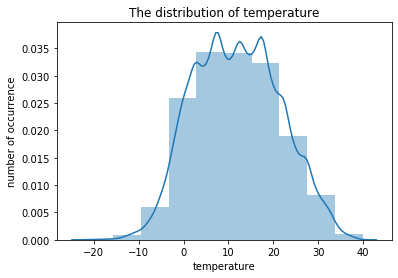

In [13]:
#plottinf figure
sns.distplot(weather_c.temperature, bins = 10)
plt.title("The distribution of temperature")
plt.xlabel("temperature")
plt.ylabel("number of occurrence")
plt.show()

It is kind of normally distributed, littlebit skewed to right.

Correlation:

In [14]:
#lets see the correlation of features
weather_c.corr()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,pressure,year,month,day,hour
temperature,1.000000,0.992629,-0.632255,0.008957,0.029988,0.392847,-0.005447,0.017462,0.148576,-0.000802,0.099540
apparenttemperature,0.992629,1.000000,-0.602571,-0.056650,0.029031,0.381718,-0.000219,0.017171,0.157986,0.001743,0.096036
humidity,-0.632255,-0.602571,1.000000,-0.224951,0.000735,-0.369173,0.005454,0.039257,0.056526,0.004851,-0.159930
windspeed,0.008957,-0.056650,-0.224951,1.000000,0.103822,0.100749,-0.049263,-0.004245,-0.098905,-0.006659,0.011118
windbearing,0.029988,0.029031,0.000735,0.103822,1.000000,0.047594,-0.011651,-0.025685,-0.019208,-0.003490,-0.003520
visibility,0.392847,0.381718,-0.369173,0.100749,0.047594,1.000000,0.059818,0.107306,-0.071946,-0.026374,0.103589
pressure,-0.005447,-0.000219,0.005454,-0.049263,-0.011651,0.059818,1.000000,0.016124,-0.019308,-0.015452,-0.005715
year,0.017462,0.017171,0.039257,-0.004245,-0.025685,0.107306,0.016124,1.000000,-0.000405,0.000425,-0.000075
month,0.148576,0.157986,0.056526,-0.098905,-0.019208,-0.071946,-0.019308,-0.000405,1.000000,0.010228,-0.000002
day,-0.000802,0.001743,0.004851,-0.006659,-0.003490,-0.026374,-0.015452,0.000425,0.010228,1.000000,0.000003


OBS:
temperature is highly correlated to apparent temperature almost about 1.0, humidity is negatively highly correlated  and then little bit correlated to visibility, but other features shows minimal correlation to target feature.

Visualization: visualising relationship through bar graph of target feature vs other features.

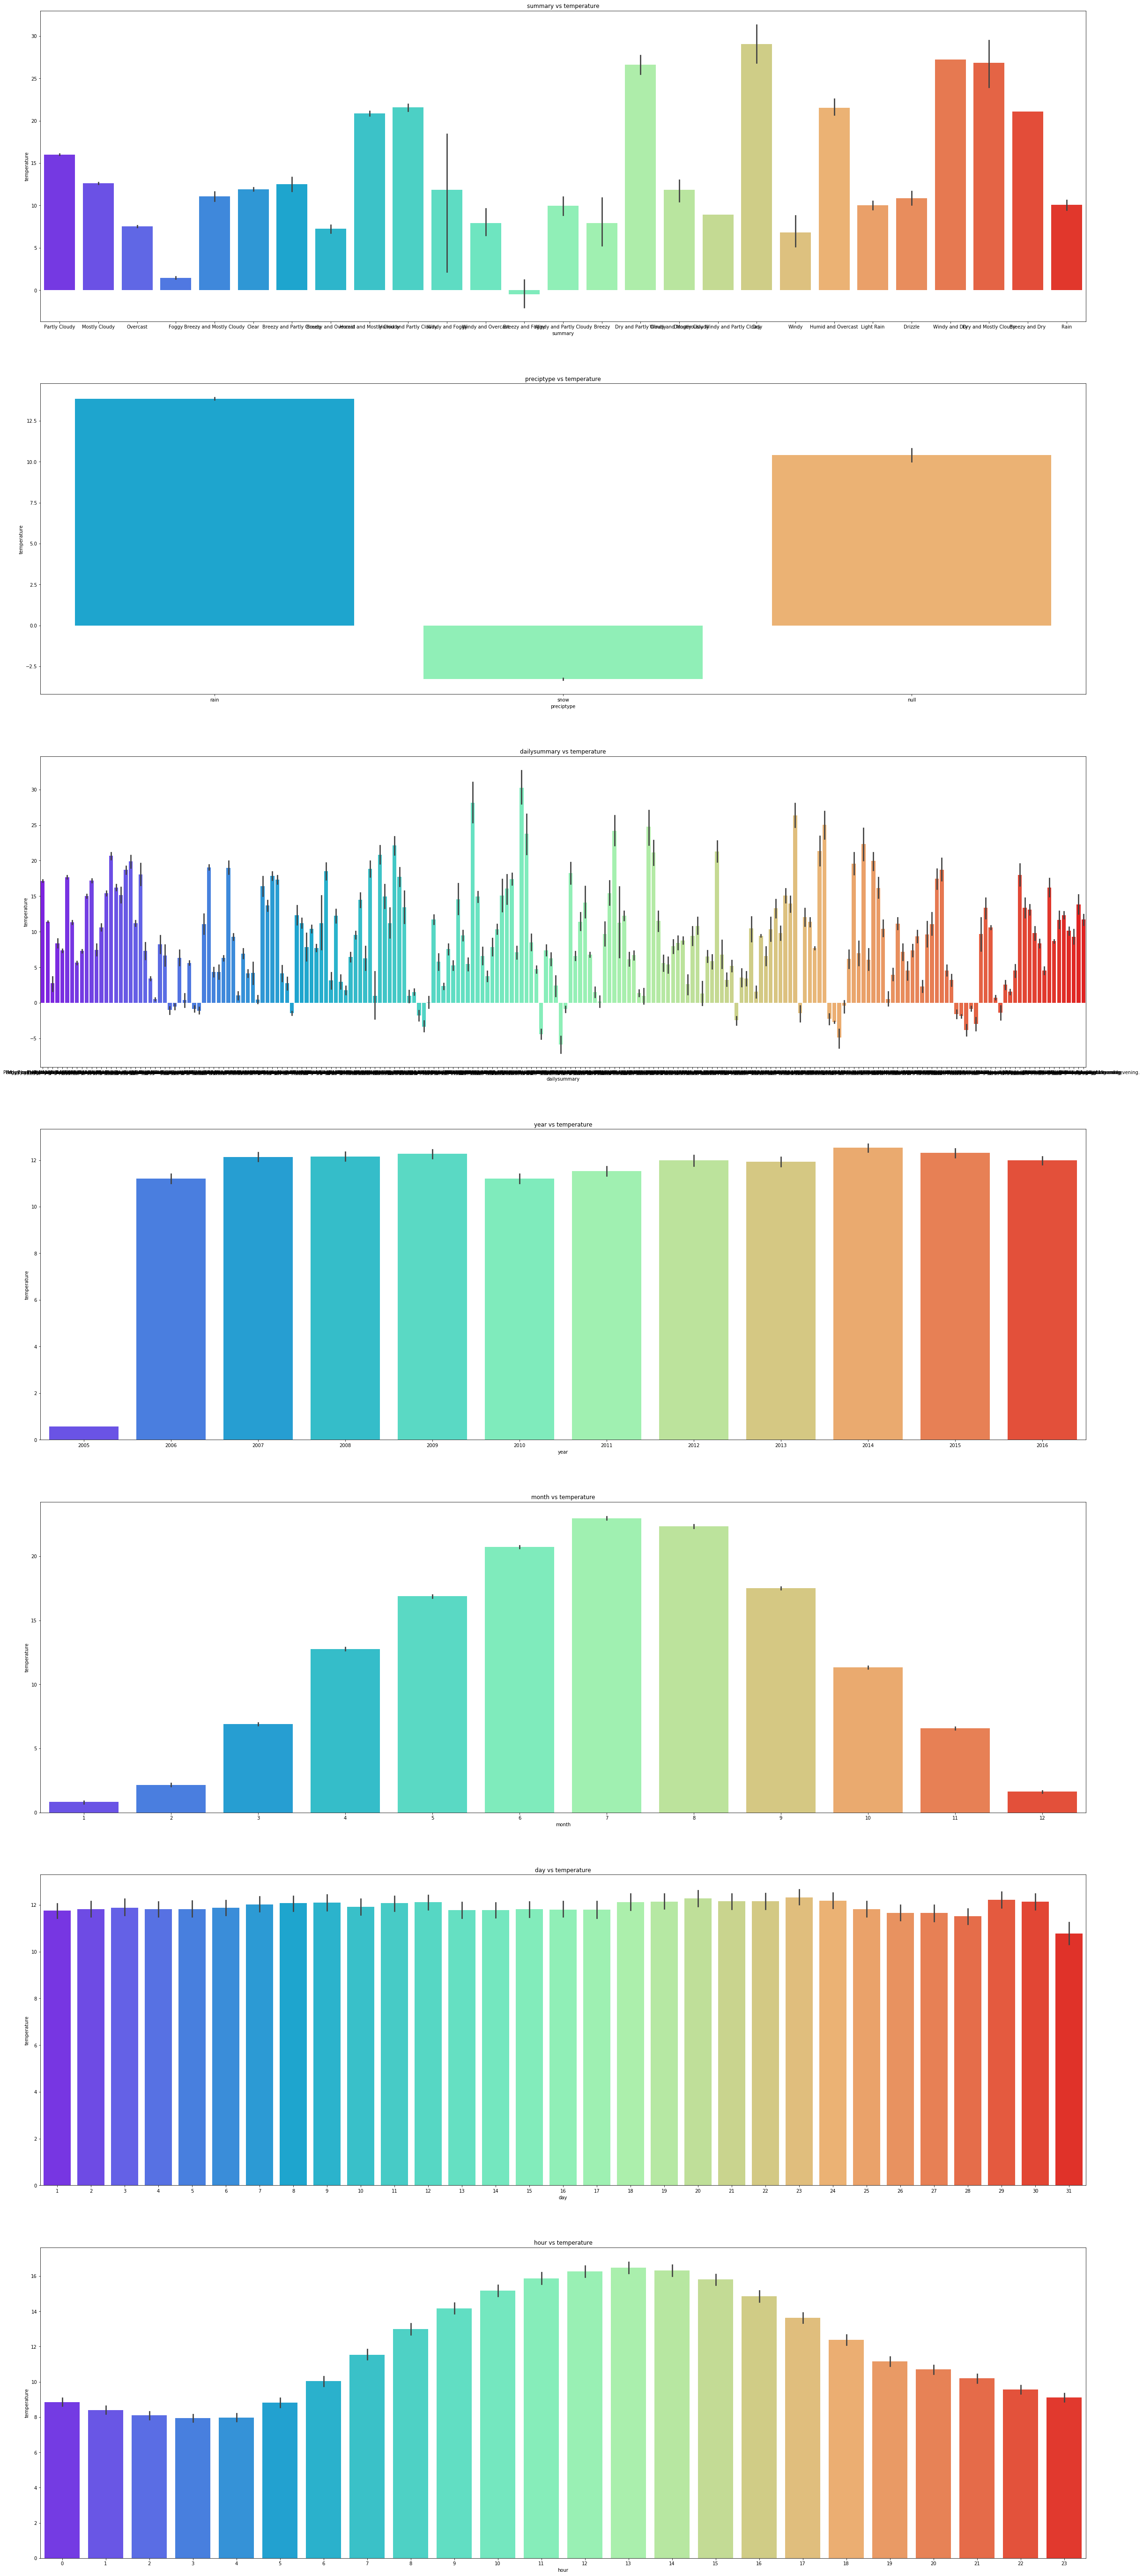

In [15]:
#finding ground relation of each features to target using histogram

plt.figure(figsize=(40,100))

plt.subplot(7,1,1)
sns.barplot(weather_c['summary'], weather_c['temperature'], palette='rainbow')
plt.title("summary vs temperature")

plt.subplot(7,1,2)
sns.barplot(weather_c['preciptype'], weather_c['temperature'], palette='rainbow')
plt.title("preciptype vs temperature")


plt.subplot(7,1,3)
sns.barplot(weather_c['dailysummary'], weather_c['temperature'], palette='rainbow')
plt.title("dailysummary vs temperature")

plt.subplot(7,1,4)
sns.barplot(weather_c['year'], weather_c['temperature'], palette='rainbow')
plt.title("year vs temperature")

plt.subplot(7,1,5)
sns.barplot(weather_c['month'], weather_c['temperature'], palette='rainbow')
plt.title("month vs temperature")

plt.subplot(7,1,6)
sns.barplot(weather_c['day'], weather_c['temperature'], palette='rainbow')
plt.title("day vs temperature")


plt.subplot(7,1,7)
sns.barplot(weather_c['hour'], weather_c['temperature'], palette='rainbow')
plt.title("hour vs temperature")


plt.show()

OBS:




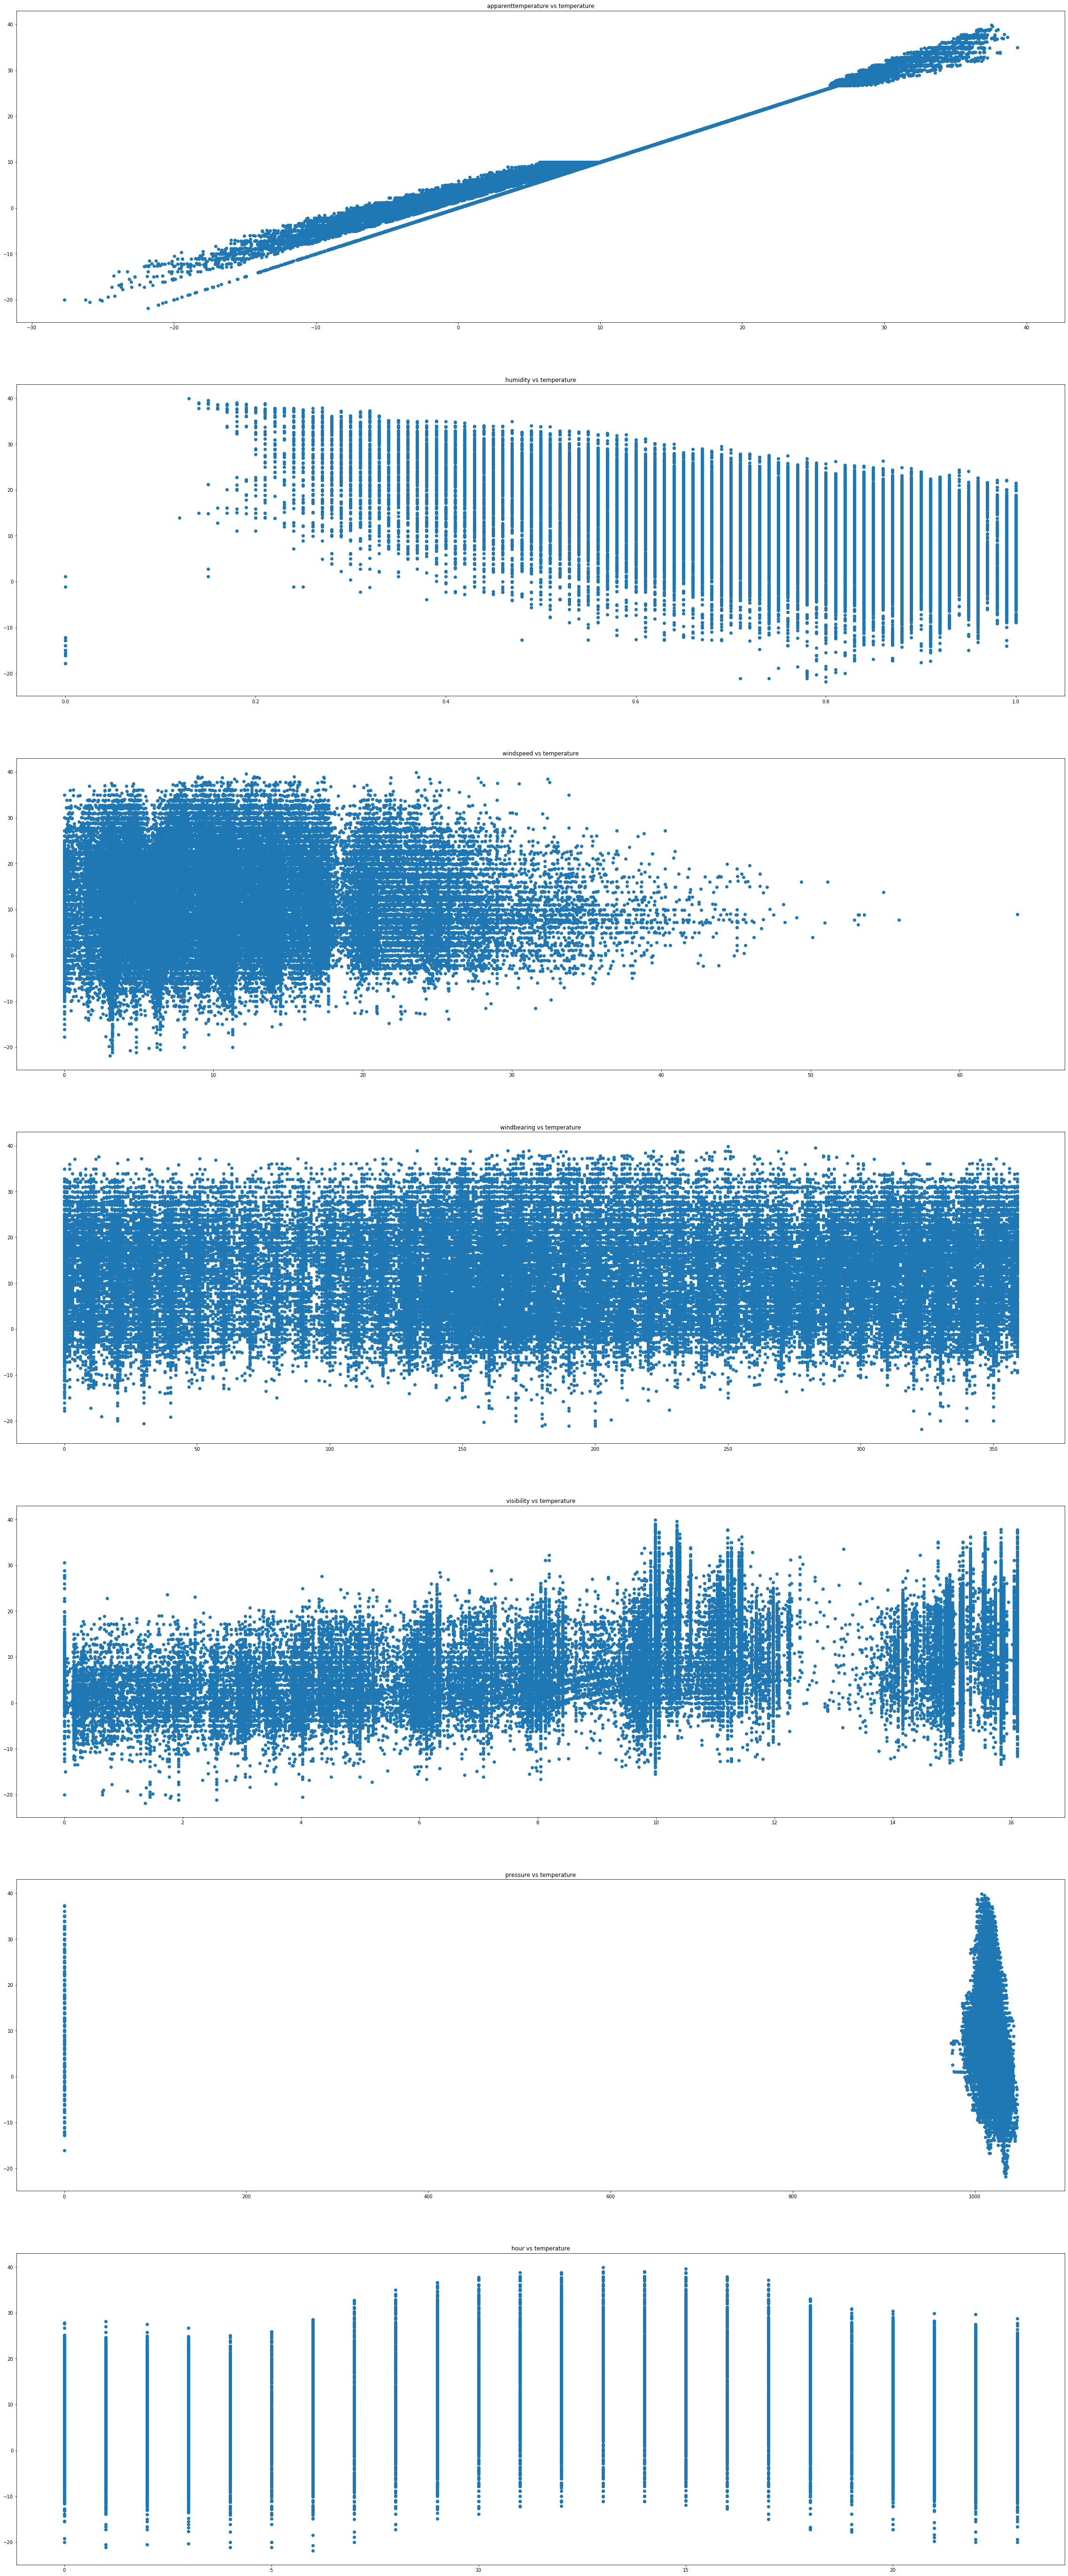

In [16]:
#finding ground relation of each features to target using histogram

plt.figure(figsize=(40,100))


plt.subplot(7,1,1)
plt.scatter(weather_c['apparenttemperature'], weather_c['temperature'])
plt.title("apparenttemperature vs temperature")

plt.subplot(7,1,2)
plt.scatter(weather_c['humidity'], weather_c['temperature'])
plt.title("humidity vs temperature")


plt.subplot(7,1,3)
plt.scatter(weather_c['windspeed'], weather_c['temperature'])
plt.title("windspeed vs temperature")

plt.subplot(7,1,4)
plt.scatter(weather_c['windbearing'], weather_c['temperature'])
plt.title("windbearing vs temperature")

plt.subplot(7,1,5)
plt.scatter(weather_c['visibility'], weather_c['temperature'])
plt.title("visibility vs temperature")

plt.subplot(7,1,6)
plt.scatter(weather_c['pressure'], weather_c['temperature'])
plt.title("pressure vs temperature")


plt.subplot(7,1,7)
plt.scatter(weather_c['hour'], weather_c['temperature'])
plt.title("hour vs temperature")


plt.show()

OBS:



### Feature Engineering:

In [17]:
dummy = pd.get_dummies(weather_c[['summary', 'preciptype']])
dummy.head()

,summary_Breezy,summary_Breezy and Dry,summary_Breezy and Foggy,summary_Breezy and Mostly Cloudy,summary_Breezy and Overcast,summary_Breezy and Partly Cloudy,summary_Clear,summary_Dangerously Windy and Partly Cloudy,summary_Drizzle,summary_Dry,...,summary_Rain,summary_Windy,summary_Windy and Dry,summary_Windy and Foggy,summary_Windy and Mostly Cloudy,summary_Windy and Overcast,summary_Windy and Partly Cloudy,preciptype_null,preciptype_rain,preciptype_snow
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
weather_c = pd.concat([weather_c, dummy], axis=1)
weather_c.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,pressure,...,summary_Rain,summary_Windy,summary_Windy and Dry,summary_Windy and Foggy,summary_Windy and Mostly Cloudy,summary_Windy and Overcast,summary_Windy and Partly Cloudy,preciptype_null,preciptype_rain,preciptype_snow
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,...,0,0,0,0,0,0,0,0,1,0
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,...,0,0,0,0,0,0,0,0,1,0
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,...,0,0,0,0,0,0,0,0,1,0
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,...,0,0,0,0,0,0,0,0,1,0
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,...,0,0,0,0,0,0,0,0,1,0


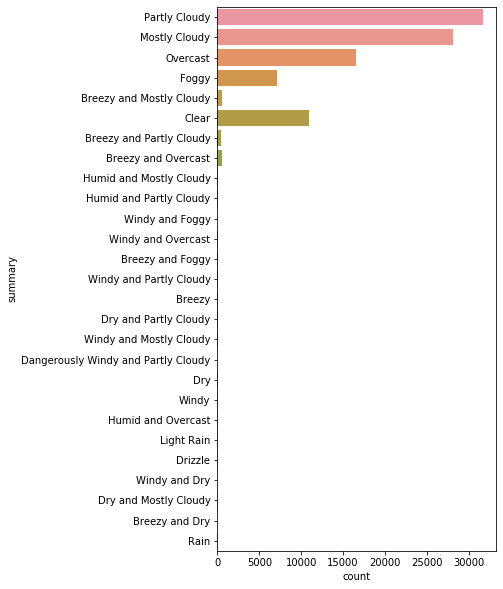

In [19]:
plt.figure(figsize=(5,10))
sns.countplot(y=weather_c['summary'])
plt.show()

OBS:


### Feature Selection:

In [20]:


def cloud_categorizer(row):
   row = str(row).lower()
   category = ""
   if "foggy" in row:
       category = 5
   elif "overcast" in row:
       category = 4
   elif "mostly cloudy" in row:
       category = 3
   elif "partly cloudy" in row:
       category = 2
   elif "clear" in row:
       category = 1
   else:
       category = 0
   return category 


In [21]:
weather_c["cloud (summary)"] = weather_c.apply (lambda row:cloud_categorizer(row["summary"]) , axis = 1)

In [22]:
weather_c.corr()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,pressure,year,month,day,...,summary_Windy,summary_Windy and Dry,summary_Windy and Foggy,summary_Windy and Mostly Cloudy,summary_Windy and Overcast,summary_Windy and Partly Cloudy,preciptype_null,preciptype_rain,preciptype_snow,cloud (summary)
temperature,1.000000,0.992629,-0.632255,0.008957,0.029988,0.392847,-0.005447,0.017462,0.148576,-0.000802,...,-0.004890,0.005154,-0.000038,-0.000196,-0.009047,-0.005423,-0.011833,0.553873,-0.562620,-0.351283
apparenttemperature,0.992629,1.000000,-0.602571,-0.056650,0.029031,0.381718,-0.000219,0.017171,0.157986,0.001743,...,-0.007532,0.004663,-0.000654,-0.001961,-0.014458,-0.010608,-0.009554,0.555889,-0.565207,-0.347263
humidity,-0.632255,-0.602571,1.000000,-0.224951,0.000735,-0.369173,0.005454,0.039257,0.056526,0.004851,...,-0.007567,-0.008152,0.005439,-0.013149,-0.002899,-0.027798,0.004044,-0.228314,0.232113,0.374726
windspeed,0.008957,-0.056650,-0.224951,1.000000,0.103822,0.100749,-0.049263,-0.004245,-0.098905,-0.006659,...,0.041306,0.013711,0.031082,0.089033,0.101774,0.128899,0.011240,0.063988,-0.067928,0.063612
windbearing,0.029988,0.029031,0.000735,0.103822,1.000000,0.047594,-0.011651,-0.025685,-0.019208,-0.003490,...,0.011216,-0.001125,-0.001950,0.013115,0.011428,0.026421,-0.001210,0.041406,-0.041984,-0.024077
visibility,0.392847,0.381718,-0.369173,0.100749,0.047594,1.000000,0.059818,0.107306,-0.071946,-0.026374,...,0.000793,-0.000281,-0.012971,0.003692,-0.002788,0.007149,-0.048994,0.317667,-0.312875,-0.476806
pressure,-0.005447,-0.000219,0.005454,-0.049263,-0.011651,0.059818,1.000000,0.016124,-0.019308,-0.015452,...,-0.068197,0.000467,0.000481,-0.003813,0.000593,-0.011258,0.010006,-0.011103,0.009008,0.080203
year,0.017462,0.017171,0.039257,-0.004245,-0.025685,0.107306,0.016124,1.000000,-0.000405,0.000425,...,0.002879,0.001018,-0.002037,-0.000174,-0.003342,-0.009958,0.090384,0.024660,-0.046176,0.047939
month,0.148576,0.157986,0.056526,-0.098905,-0.019208,-0.071946,-0.019308,-0.000405,1.000000,0.010228,...,-0.008644,-0.002356,-0.002844,-0.016623,-0.009542,-0.022485,0.042806,0.133773,-0.146497,-0.024914
day,-0.000802,0.001743,0.004851,-0.006659,-0.003490,-0.026374,-0.015452,0.000425,0.010228,1.000000,...,-0.002175,0.004855,-0.002178,-0.001883,0.000452,-0.000121,0.039814,-0.018632,0.009766,-0.003103


OBS:
use preciptype_rain	 instead of preciptype_snow.


PCA: could use visibility, cloud (summary)
preciptype_rain, humidity	

In [23]:
X2 = weather_c[["visibility", "cloud (summary)", "preciptype_rain", "humidity", "apparenttemperature"]]

X2 = StandardScaler().fit_transform(X2)

sklearn_pca = PCA(n_components=1)
weather_c["pca_1"] = sklearn_pca.fit_transform(X2)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.51173062]


In [24]:
weather_c1 = weather_c[["temperature","pca_1",  "apparenttemperature", "humidity", "visibility", "preciptype_rain",
                      "cloud (summary)", "preciptype_snow"]]
weather_c1.corr()

,temperature,pca_1,apparenttemperature,humidity,visibility,preciptype_rain,cloud (summary),preciptype_snow
temperature,1.000000,-0.838890,0.992629,-0.632255,0.392847,0.553873,-0.351283,-0.562620
pca_1,-0.838890,1.000000,-0.829107,0.737963,-0.706907,-0.629292,0.656444,0.627308
apparenttemperature,0.992629,-0.829107,1.000000,-0.602571,0.381718,0.555889,-0.347263,-0.565207
humidity,-0.632255,0.737963,-0.602571,1.000000,-0.369173,-0.228314,0.374726,0.232113
visibility,0.392847,-0.706907,0.381718,-0.369173,1.000000,0.317667,-0.476806,-0.312875
preciptype_rain,0.553873,-0.629292,0.555889,-0.228314,0.317667,1.000000,-0.193326,-0.973759
cloud (summary),-0.351283,0.656444,-0.347263,0.374726,-0.476806,-0.193326,1.000000,0.199871
preciptype_snow,-0.562620,0.627308,-0.565207,0.232113,-0.312875,-0.973759,0.199871,1.000000


OBS:

weather_c1 for new features.

Feature Selection:

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

# Y is the target variable
Y = weather_c1['temperature']
# X is the feature set which includes
# is_male and is_smoker variables
X = weather_c1[["pca_1",  "apparenttemperature", "humidity", "visibility", "preciptype_rain", 
                "cloud (summary)", "preciptype_snow"]]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-0.81877244  0.81099973 -0.75652544 -0.06668386 -0.70634439  0.35758869
 -0.00599561]

Intercept: 
 4.013056605766217


In [28]:
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 1.249e+06
Date:                Mon, 20 Jan 2020   Prob (F-statistic):               0.00
Time:                        11:34:52   Log-Likelihood:            -1.4400e+05
No. Observations:               96453   AIC:                         2.880e+05
Df Residuals:                   96446   BIC:                         2.881e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.0114      0.054     74.952      0.000       3.907       4.116
pca_1                  -0.8468      0.010    -87.414      0.000      -0.866      -0.828
apparenttemperature     0.8096      0.001   1010.051      0.000       0.808       0.811
humidity               -0.6904      0.018    -39.439      0.000      -0.725      -0.656
visibility             -0.0696      0.002    -45.306      0.000      -0.073      -0.067
preciptype_rain        -0.7407      0.040    -18.482      0.000      -0.819      -0.662
cloud (summary)         0.3680      0.005     69.510      0.000       0.358       0.378
preciptype_snow        -0.0060      0.049     -0.123      0.902      -0.102       0.090
==============================================================================
Omnibus:                     1714.054   Durbin-Watson:                   0.407
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3201.232
Skew:                          -0.112   Prob(JB):                         0.00
Kurtosis:                       3.864   Cond. No.                     1.95e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.22e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [29]:
# Y is the target variable
Y1 = weather_c1['temperature']
# X is the feature set which includes
# is_male and is_smoker variables
X1 = weather_c1[["pca_1"]]


In [30]:
X1 = sm.add_constant(X1)

results = sm.OLS(Y1, X1).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                 2.291e+05
Date:                Mon, 20 Jan 2020   Prob (F-statistic):               0.00
Time:                        11:35:04   Log-Likelihood:            -2.9586e+05
No. Observations:               96453   AIC:                         5.917e+05
Df Residuals:                   96451   BIC:                         5.917e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9327      0.017    712.821      0.000      11.900      11.965
pca_1         -5.0092      0.010   -478.651      0.000      -5.030      -4.989
==============================================================================
Omnibus:                     1639.292   Durbin-Watson:                   0.185
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1357.168
Skew:                          -0.223   Prob(JB):                    1.97e-295
Kurtosis:                       2.626   Cond. No.                         1.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Section 2:
Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.

Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

In [31]:

# Y is the target variable
Y2 = weather_c['temperature']
# X is the feature set which includes
# is_male and is_smoker variables
X2 = weather_c[["humidity", "windspeed", "windbearing", "pressure"]]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X2, Y2)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.92643818528537



Coefficients: 
 [2. 3.]

Intercept: 
 0.999999999650754


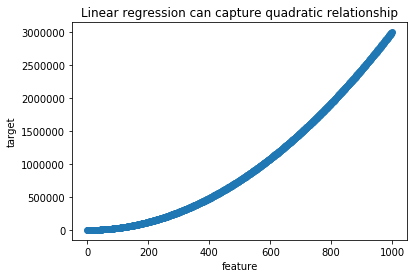

In [32]:
df = pd.DataFrame()

# data from 0 to 999
df["X2"] = np.arange(0,1000,1)
# we take the square of X
df["X_sq"] = df["X2"]**2

# this is our equation: Y = 1 + 2*X + 3*X^2
df["Y2"] = 1 + 2*df["X2"] + 3*df["X_sq"]

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df[["X2","X_sq"]],df["Y2"])

# predictions of the linear regression
predictions = lrm_example.predict(df[["X2","X_sq"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df["X2"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

Obs:


In [34]:
predictions = lrm.predict(X2)
errors = Y2 - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -1.9624955657832385e-15


OBS:

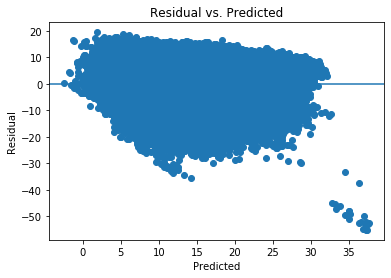

In [35]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

homoscedasticity

Here, we demonstrate two of them: Bartlett and Levene tests. The null hypothesis for both tests is that the errors are homoscedastic. Both tests can be imported from scipy's stats module.

In [36]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are heteroscedastic.

Assumption four: low multicollinearity¶

In [37]:
X2 = sm.add_constant(X2)

results = sm.OLS(Y2, X2).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.750e+04
Date:                Mon, 20 Jan 2020   Prob (F-statistic):               0.00
Time:                        11:40:12   Log-Likelihood:            -3.2821e+05
No. Observations:               96453   AIC:                         6.564e+05
Df Residuals:                   96448   BIC:                         6.565e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.9264      0.233    162.709      0.000      37.470      38.383
humidity      -32.4962      0.123   -264.288      0.000     -32.737     -32.255
windspeed      -0.2014      0.003    -57.557      0.000      -0.208      -0.195
windbearing     0.0040      0.000     18.463      0.000       0.004       0.004
pressure       -0.0007      0.000     -3.452      0.001      -0.001      -0.000
==============================================================================
Omnibus:                     3375.432   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3793.297
Skew:                          -0.455   Prob(JB):                         0.00
Kurtosis:                       3.339   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

OBS:

Assumption five: error terms should be uncorrelated with one another

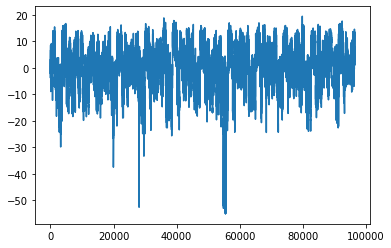

In [38]:
plt.plot(errors)
plt.show()

It seems that the error terms of our model are uncorrelated with each other.

Another way to look at correlations between errors is to use the autocorrelation function. This function computes the correlation of a variable with itself. In our case, the order of the errors are the orders of the observations. We can use the acf() function from statsmodels as follows:

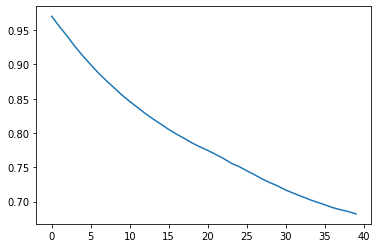

In [39]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

OBS:

Assumption six: features shouldn't be correlated with the errors

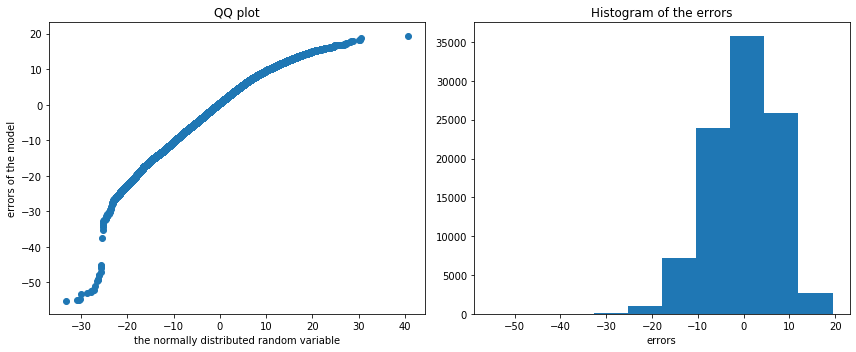

In [40]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

OBS: 
Almost normal, not very far, skewed to left little bit.

Lets apply:
Jarque Bera and normal tests. The null hypothesis of both tests is that the errors are normally distributed.

Let's use these tests to find out whether our error terms are normally distributed or not:

In [41]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.296735252356 and p value is 0.0
Normality test statistics is 3375.4323076995797 and p value is 0.0


OBS:
p value lower than 0.05, rejecting null hypothesis, indicates that the errors are not normally distributed.

### Section 3:

Build a linear regression model where your target variable is the difference between the apparenttemperature and the temperature. 

As explanatory variables, use humidity and windspeed. Now, estimate your model using OLS. 
     - Are the estimated coefficients statistically significant? 
     - Are the signs of the estimated coefficients in line with your previous expectations? 
     - Interpret the estimated coefficients. What are the relations between the target and the explanatory variables?

Next, include the interaction of humidity and windspeed to the model above and estimate the model using OLS. Are the coefficients statistically significant? Did the signs of the estimated coefficients for humidity and windspeed change? Interpret the estimated coefficients.

In [43]:
weather_c1['target_temp'] = weather_c1['temperature'] - weather_c1['apparenttemperature']
# Y is the target variable
Y3 = weather_c1['target_temp']
# X is the feature set which includes
# is_male and is_smoker variables
X3 = weather_c[["humidity", "windspeed"]]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X3, Y3)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [3.02918594 0.11929075]

Intercept: 
 -2.4381054151876933


In [44]:
X3 = sm.add_constant(X3)

results = sm.OLS(Y3, X3).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            target_temp   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 1.949e+04
Date:                Mon, 20 Jan 2020   Prob (F-statistic):               0.00
Time:                        12:14:09   Log-Likelihood:            -1.7046e+05
No. Observations:               96453   AIC:                         3.409e+05
Df Residuals:                   96450   BIC:                         3.409e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4381      0.021   -115.948      0.000      -2.479      -2.397
humidity       3.0292      0.024    126.479      0.000       2.982       3.076
windspeed      0.1193      0.001    176.164      0.000       0.118       0.121
==============================================================================
Omnibus:                     3935.747   Durbin-Watson:                   0.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4613.311
Skew:                           0.478   Prob(JB):                         0.00
Kurtosis:                       3.484   Cond. No.                         88.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

OBS:
no multicollinearity
std err is low

#### Statistical significance of target to variables:

- statistical significance
- t-test
- t-value
- p-value
- inference and the relationship between estimated coefficients and the target
- interpreting continuous and categorical variables
- interpreting interaction terms
- interpreting constants

OBS:
- From OLS, we can see that constant is -2.4381, humidity coeficient is 3.0292, and windspeed coeficient is 0.1193 giving estimated model as:

weather = -2.4381 + 3.0292 humidity + 0.1193 windspeed.

- This is a controlled experiment.
- As we can see, p-value of all coefficient is near to 0 which means they are statistically significant to target variable.
- For every % increament in humidity temperature increases by 3.0292, and for every KT of windspeed temperature increases by 0.1193.
- looking at standard error it is really low for windspeed than compare to others, which is 0.001.

#### Checking for an Interaction terms:

We can make interaction between humidity and windspeed to see the effects of interaction terms to new target temperature:


In [46]:
weather_c1['target_temp'] = weather_c1['temperature'] - weather_c1['apparenttemperature']
# Y is the target variable
Y3 = weather_c1['target_temp']

#making interaction terms using humidity and windspeed
weather_c['hum_wind'] = weather_c['humidity'] * weather_c['windspeed']
# X is the feature set which includes
# humidity and windspeed
X3 = weather_c[["humidity", "windspeed", "hum_wind"]]

# We add a constant to the model as it's a best practice
# to do so every time!
X3 = sm.add_constant(X3)

# We fit an OLS model using statsmodels
results = sm.OLS(Y3, X3).fit()

# We print the summary results
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            target_temp   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                 1.666e+04
Date:                Wed, 22 Jan 2020   Prob (F-statistic):               0.00
Time:                        11:53:39   Log-Likelihood:            -1.6669e+05
No. Observations:               96453   AIC:                         3.334e+05
Df Residuals:                   96449   BIC:                         3.334e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0839      0.033     -2.511      0.012      -0.149      -0.018
humidity      -0.1775      0.043     -4.133      0.000      -0.262      -0.093
windspeed     -0.0905      0.002    -36.797      0.000      -0.095      -0.086
hum_wind       0.2971      0.003     88.470      0.000       0.291       0.304
==============================================================================
Omnibus:                     4849.937   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9295.404
Skew:                           0.378   Prob(JB):                         0.00
Kurtosis:                       4.320   Cond. No.                         193.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

OBS:
- After using interaction terms, we can see that p-value is still around 0 for all and statistically significant to target.
- standard error is still low for windspeed than any other variables.
- After interaction terms, all other coefficient became negative to target, which means there will be decrease in temperature for every increament in humidity or windspeed, but will be increament in temperature for every increament in hum_wind.
- t-value decreases for all variables here, and is lower for humidity and positve for hum_wind.
- this model little skew than the previous one.